# Reimplementation from scatch of YOLOv8 for Car Detection - Testing
This notebook contains the implementation of the Yolo-v8 architecture. We use it for car detection.

## All the Imports

In [1]:
import torch
import torch.nn as nn
import pytorch_lightning as pl
from torch.utils.data import DataLoader, Dataset
import os
import torch
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image, ImageDraw
import pandas as pd
import torch
import torch.nn.functional as F
import numpy as np
import cv2
import matplotlib.pyplot as plt
import math
import json
import random
import matplotlib.patches as patches
import sklearn
from sklearn import *

## Constants
The constants above are used to index the encoded target and output in order to retrieve the corresponding quantities.

* `DELTA_X = 0`
* `DELTA_Y = 1`
* `WIDTH = 2`
* `HEIGHT = 3`
* `CONFIDENCE = 4`
* `CLASS = 5`

In [2]:
DELTA_X = 0
DELTA_Y = 1
WIDTH = 2
HEIGHT = 3
CONFIDENCE = 4
CLASS = 5

## Utils Function

* `scale_to_range`: scales bounding boxes to a new range 
* `show_image_with_boxes`: displays an image with its bounding boxes
* `from_grid_coordinates_to_bbox`: converts grid coordinates ($\Delta x_c, \Delta y_c, \Delta w, \Delta h$) to bounding boxes coordinates ($x_c, y_c, h, w$)
* `transform_in_grid_coordinates`: converts bounding boxes coordinates ($x_c, y_c, h, w$) in grid coordinates ($\Delta x_c, \Delta y_c, \Delta w, \Delta h$)


In [3]:
def scale_to_range(bboxes, old_x=676, old_y=380, new_x = 128, new_y=128):
    x_scale = new_x / old_x
    y_scale = new_y / old_y
    
    for box in bboxes:
        box[0] = int(np.round(box[0]*x_scale))
        box[1] = int(np.round(box[1]*y_scale))
        box[2] = int(np.round(box[2]*x_scale))
        box[3] = int(np.round(box[3]*y_scale))
    return bboxes

In [5]:
def show_image_with_boxes(self, idx):
        image, boxes_list = self[idx]
        image_draw = ImageDraw.Draw(image)
        
        # Draw the bounding boxes
        for box in boxes_list:
            xmin, ymin, xmax, ymax = box
            image_draw.rectangle([xmin, ymin, xmax, ymax], outline="red", width=2)
        
        # Display the image
        plt.imshow(image)
        plt.axis("off")
        plt.show()

In [4]:
def transform_in_grid_coordinates(x_center, y_center, width, height, size="large"):

    #print(f"la nostra bounding box è x_center = {x_center}, y_center = {y_center}, width = {width}, height = {height}\n")

    if size == "small":
        number_of_cells = 16
        n_pixel_per_grid = 8

    if size == "medium":
        number_of_cells = 8
        n_pixel_per_grid = 16

    if size == "large":
        number_of_cells = 4
        n_pixel_per_grid = 32

    i = 0
    for cell in range(number_of_cells * number_of_cells):
        #print(f"colonna = {cell}\n")
        #print(f"riga = {i}\n")

        if cell % number_of_cells  == 0:
            i += 1

        x_a = n_pixel_per_grid * (cell % number_of_cells)
        y_a = n_pixel_per_grid * (i-1) 
        #print(f"x_a = {x_a}, y_a = {y_a}\n")

        # if verifica se il centro ricade nella cella
        #print(f"controlliamo se il centro ricade tra x = {x_a} e x = {x_a + n_pixel_per_grid}...\n")
        if x_center >= x_a and x_center <= (x_a + n_pixel_per_grid):
            #print(f"controlliamo se il centro ricade tra x = {y_a} e x = {y_a + n_pixel_per_grid}...\n")
            if y_center >= y_a and y_center <= (y_a + n_pixel_per_grid):
                #print("il centro ricade qua! Calcoliamo quantità!\n")
                delta_x = (x_center - x_a) / n_pixel_per_grid
                delta_y = (y_center - y_a) / n_pixel_per_grid
                delta_width = width / 128
                delta_height = height / 128 # 128 is the heigth and width of the image
                #print(f"delta_x = {delta_x}, delta_y = {delta_y}, delta_width = {delta_width}, delta_height = {delta_height}")
                confidence = 1 # 100% confidence that is a car
                cl = 1 # 1 = car, 0 = nothing
                column = cell
                row = i-1
                return delta_x, delta_y, delta_width, delta_height, confidence, cl, column%number_of_cells, row
            else:
                continue
        else:
              continue
        print("[ERROR]: there is a box but we have not found the cell in which it lies")



In [6]:
def show_image_and_bbox(image, encoding_of_boxes, filename=None, training=False):
    
    image_np = None

    # if a filename is not provided, a 128 x 128 image is displayed
    if filename == None:
        image = image[0]

        if image.shape == torch.Size([3, 128, 128]):
            image_np = image.permute(1, 2, 0).numpy()

    # if a filename is provided, the 676 x 380 image is displayed
    else:
        img_path = os.path.join("/kaggle/input/car-object-detection/data/testing_images", filename)
    
        if training == True:
            img_path = os.path.join("/kaggle/input/car-object-detection/data/training_images", filename)
    
        image = Image.open(img_path).convert("RGB")
        image_np = np.array(image)
            
    # Plot the image with bounding boxes
    fig, ax = plt.subplots(1)
    ax.imshow(image_np)
    
    bboxes = from_grid_coordinate_to_bbox(encoding_of_boxes)

    for box in bboxes:
        
        #print(f"box = {box}")

        x_center = box[0]
        y_center = box[1]
        width = box[2]
        height = box[3]
        
        xmin = (2*x_center - width) / 2
        ymin = (2*y_center - height) / 2
        xmax = (2*x_center + width) / 2
        ymax = (2*y_center + height) / 2
        
        rect = None
        # if a filename is not provided, the image is 128 x 128 and so the box should be
        if filename == None:
            rect = patches.Rectangle((xmin, ymin), width, height, linewidth=2, edgecolor='r', facecolor='none')
        
        # if the image is 676 x 380, the rectangle must be scaled
        else:
            bbox = scale_to_range(bboxes=[[xmin, ymin, xmax, ymax]], old_x=128, old_y=128, new_x=676, new_y=380)
            bbox = bbox[0]
            xmin = bbox[0]
            ymin = bbox[1]
            xmax = bbox[2]
            ymax = bbox[3]
            width = xmax - xmin
            height = ymax - ymin
            rect = patches.Rectangle((xmin, ymin), width, height, linewidth=2, edgecolor='r', facecolor='none')
        
        
        # Add the patch to the Axes
        ax.add_patch(rect)
        
        
        confidence_score = box[4]
        ax.text(xmin, ymin - 5, f'{confidence_score:.4f}', color='white', fontsize=12, bbox=dict(facecolor='red', alpha=0.5))

    
    plt.axis('off')  # Turn off axis
    plt.show()
    
    return 

In [7]:
def from_grid_coordinate_to_bbox(output, size="large", iou_flag=False):
        
        if size == "small":
            number_of_cells = 16
            n_pixel_per_grid = 8
        
        if size == "medium":
            number_of_cells = 8
            n_pixel_per_grid = 16
        
        if size == "large":
            number_of_cells = 4
            n_pixel_per_grid = 32
    
        bboxes = []
        for i in range(number_of_cells):
            for j in range(number_of_cells):
                
                if output[0][CLASS][i][j] >= 0.6:
                    delta_x = float(output[0][DELTA_X][i][j])
                    delta_y = float(output[0][DELTA_Y][i][j])
                    delta_w = float(output[0][WIDTH][i][j])
                    delta_h = float(output[0][HEIGHT][i][j])

                    x_a = n_pixel_per_grid * j
                    y_a = n_pixel_per_grid * i

                    x = delta_x * n_pixel_per_grid + x_a
                    y = delta_y * n_pixel_per_grid + y_a
                    w = delta_w * 128
                    h = delta_h * 128
                    confidence = float(output[0][CONFIDENCE][i][j])                 

                    bbox = [x, y, w, h, confidence]
                    #print(f"bbox = {bbox}, class = {output[0][CLASS][i][j]}")

                    # if we are calling this function for the iou calculation, we also need i and j to identify the bounding boxes
                    # and compare them between out and target
                    if iou_flag == True:
                        bboxes.append((bbox, i, j))
                    
                    else:
                        bboxes.append(bbox)
                    

        return bboxes                 

### YOLO Architecture

Check the train notebook for details on the implementation

In [8]:
DEBUG = False
DEBUG_2 = False

class ConvBlock(nn.Module):
    def __init__(self, k, s, p, c=3, dim=64, mc=512, w=1,flag=1):
        super(ConvBlock, self).__init__()
        dim = int(dim)
        out = min(dim,mc)*w
        self.conv = nn.Conv2d(in_channels=c, out_channels=out, kernel_size=k, stride=s, padding=p)
        self.batch_norm = nn.BatchNorm2d(num_features=out)
        self.activation = nn.SiLU()
    
    def forward(self, x):
        x = self.conv(x)
        x = self.batch_norm(x)
        x = self.activation(x)
        return x
    

class Bottleneck(nn.Module):
    def __init__(self, k=3, s=1, p=1, c=3, dim=64, shortcut=True):
        super(Bottleneck, self).__init__()
        self.conv1 = ConvBlock(k,s,p,c,dim=dim,mc=512)
        self.conv2 = ConvBlock(k,s,p,c,dim=dim,mc=512)
        self.short = shortcut

    
    def forward(self, x):
        #print(x.shape)
        #print(self.conv1)
        #print(self.conv2)
        if self.short: 
            res = self.conv1(x)
            res = self.conv2(res)
            return x + res
        else: 
            res = self.conv1(x)
            res = self.conv2(x)
            return res 
            
class C2fBlock(nn.Module):
    def __init__(self, k=1, s=1, p=0, c=3, depth_multiple=1, shortcut=True, dim=64, mc=512, w=1, flag=1):
        super(C2fBlock, self).__init__() 
        self.conv1 = ConvBlock(k=1,s=1,p=0,c=c,dim=dim,mc=mc,w=w,flag=flag)
        half_c= int(dim / 2)
        if half_c == 512:
            half_dim = 512
        else:
            half_dim= int(dim / 2)
            
        if flag == 0: 
            self.bottlenecks = nn.ModuleList([Bottleneck(k=3,s=1,p=1,c=256,dim=256) for _ in range(depth_multiple)])
            new_input = int(512 / 2) * (depth_multiple + 2)
            self.conv2 = ConvBlock(k,s,p,c=new_input,dim=dim,mc=mc,w=w)
        else:
            self.bottlenecks = nn.ModuleList([Bottleneck(k=3,s=1,p=1,c=half_c,dim=half_dim) for _ in range(depth_multiple)])
            new_input = int(dim / 2) * (depth_multiple + 2)
            self.conv2 = ConvBlock(k,s,p,c=new_input,dim=dim,mc=mc,w=w)
    
    def forward(self, x):
        
        #print(f"x_input: {x.shape}")
        x = self.conv1(x)
              
       # print(f"x_conv1: {x.shape}")
        
        # Split the input tensor into two halves along the channel dimension
        x1, x2 = torch.split(x, x.size(1) // 2, dim=1)
        
        #print(f"x1: {x1.shape}, x2: {x2.shape}")
        
        
        # Process the other half (x2) through the bottlenecks
        bottleneck_outputs = []
        # append half of the input before processing
        bottleneck_outputs.append(x2.clone())
        for bott in self.bottlenecks:
            x2 = bott(x2)
            bottleneck_outputs.append(x2.clone())
            
        # this will concatenate half of the input before processing
        # and after each bottleneck processing  
        
        concatenated_bottleneck_outputs = torch.cat(bottleneck_outputs, dim=1)

        # add the other half
        x = torch.cat((x1, concatenated_bottleneck_outputs), dim=1)
        #print(f"x: {x.shape}, x1: {x1.shape}, conc: {concatenated_bottleneck_outputs.shape}")
        x = self.conv2(x)
        return x
    
class SPPF(nn.Module):
    def __init__(self, k=3, s=1, p=0, c=3, dim=64):
        super(SPPF, self).__init__() 
        
        self.conv1 = ConvBlock(k=k,s=s,p=0,c=c,dim=dim)
        self.pool1 = nn.MaxPool2d(kernel_size=5, stride=1, padding=2)
        self.pool2 = nn.MaxPool2d(kernel_size=9, stride=1, padding=4)
        self.pool3 = nn.MaxPool2d(kernel_size=13, stride=1, padding=6)
        self.conv2 = ConvBlock(k=3,s=1,p=1,c=4*c,dim=dim)
        
    def forward(self, x):
        
        x = self.conv1(x)
        pool1 = self.pool1(x)
        pool2 = self.pool2(x)
        pool3 = self.pool3(x)
        #print(f"x: {x.shape}, pool1: {pool1.shape}, pool2: {pool2.shape}, pool3: {pool3.shape}")
        x = torch.cat([x, pool1, pool2, pool3], dim=1)
        #print(f"x_conc: {x.shape}")
        x = self.conv2(x)
        return x
    
class DetectBlock(nn.Module):
    def __init__(self, k=3, s=1, p=1, c=3, reg_max=1, nc=1, mc=512, w=1):
        super(DetectBlock, self).__init__()
        
        #reg_max = controlla la precisione della regression sulla bounding box 
        #nc = number of classes
        self.box_conv1 = ConvBlock(k,s,p,c=c,dim=64)
        self.box_conv2 = ConvBlock(k,s,p,c=64,dim=64)
        #self.box_conv3 = nn.Conv2d(in_channels=64, out_channels=4*reg_max, kernel_size=1, stride=1, padding=0)
        # 4 + 1 + 1 = 6 out_channels
        self.box_conv3 = nn.Conv2d(in_channels=64, out_channels=6, kernel_size=1, stride=1, padding=0)
        
        
        #self.class_conv1 = ConvBlock(k,s,p,c,dim=64)
        #self.class_conv2 = ConvBlock(k,s,p,c=64,dim=64)
        #self.class_conv3 = nn.Conv2d(in_channels=64, out_channels=nc, kernel_size=1, stride=1, padding=0)
        
    def forward(self, x): 
        
        if DEBUG_2:
            print("[Detect:]")
            print(f"Input: {x.shape}")
            print("\t [Conv]")
        ret1 = self.box_conv1(x)
        if DEBUG_2:
            print(f"Output: {ret1.shape}")
            print("\t [Conv]")
        ret1 = self.box_conv2(ret1)
        if DEBUG_2:
            print(f"Output: {ret1.shape}")
            print("\t [Conv2D]")
            print(self.box_conv3)
        ret1 = self.box_conv3(ret1)
        if DEBUG_2:
            print(f"Output: {ret1.shape}")
        
        #ret2 = self.class_conv1(x)
        #ret2 = self.class_conv2(ret2)
        #ret2 = self.class_conv3(ret2)
        
        return ret1#, ret2
               
class BackBone(nn.Module):
    def __init__(self, k=3, s=2, p=1, depth=1):
        super(BackBone, self).__init__()
        
        self.conv1 = ConvBlock(k,s,p)
        self.conv2 = ConvBlock(k,s,p, dim=128, c=64)
        self.c2f = C2fBlock(k=1,s=1,p=0,depth_multiple=3*depth,dim=128, c=128)
        self.conv3 = ConvBlock(k,s,p, dim=256, c=128)
        self.c2f_second = C2fBlock(k=1,s=1,p=0,depth_multiple=6*depth,dim=256, c=256)
        self.conv4 = ConvBlock(k,s,p,dim=512, c=256)
        self.c2f_third = C2fBlock(k=1,s=1,p=0,depth_multiple=6*depth,dim=512, c=512)
        self.conv5 = ConvBlock(k,s,p,dim=1024, c=512)
        self.c2f_last = C2fBlock(k=1,s=1,p=0,depth_multiple=3*depth,dim=min(1024,512), c=512)
        
    def forward(self, x):
        if DEBUG:
            print("[Layer: Conv 0]")
            print(f"Input Tensor Shape:  {x.shape}")
        x = self.conv1(x)
        if DEBUG:
            print(f"Output Tensor Shape: {x.shape}")

            print("[Layer: Conv 1]")
            print(f"Input Tensor Shape:  {x.shape}")
        x = self.conv2(x)
        if DEBUG:
            print(f"Output Tensor Shape: {x.shape}")

            print("[Layer: C2f 2]")
            print(f"Input Tensor Shape:  {x.shape}")
        x = self.c2f(x)
        if DEBUG:
            print(f"Output Tensor Shape: {x.shape}")

            print("[Layer: Conv 3]")
            print(f"Input Tensor Shape:  {x.shape}")        
        x = self.conv3(x)
        if DEBUG:
            print(f"Output Tensor Shape: {x.shape}")

            print("[Layer: C2f 4]")
            print(f"Input Tensor Shape:  {x.shape}") 
        x_first = self.c2f_second(x)
        if DEBUG:
            print(f"Output Tensor Shape: {x_first.shape}")

            print("[Layer: Conv 5]")
            print(f"Input Tensor Shape:  {x_first.shape}") 
        x = self.conv4(x_first)
        if DEBUG:
            print(f"Output Tensor Shape: {x.shape}")

            print("[Layer: C2f 6]")
            print(f"Input Tensor Shape:  {x.shape}") 
        x_second = self.c2f_third(x)
        if DEBUG:
            print(f"Output Tensor Shape: {x_second.shape}")

            print("[Layer: Conv 7]")
            print(f"Input Tensor Shape:  {x_second.shape}")
        x = self.conv5(x_second)
        if DEBUG:
            print(f"Output Tensor Shape: {x.shape}")

            print("[Layer: C2f 8]")
            print(f"Input Tensor Shape:  {x.shape}")
        x_last = self.c2f_last(x)
        if DEBUG:
            print(f"Output Tensor Shape: {x_last.shape}")
        
        return x_first, x_second, x_last
    
class Neck(nn.Module):
    def __init__(self, depth=1, scale=2):
        super(Neck, self).__init__()
        
        self.sppf = SPPF(k=1,dim=1024,c=512)
        self.upsample1 = nn.Upsample(scale_factor=2)
        self.upsample2 = nn.Upsample(scale_factor=2)
        self.c2f_block1 = C2fBlock(dim=512,c=1024,flag=1,shortcut=False)
        self.c2f_block2 = C2fBlock(dim=256,c=768,flag=1,shortcut=False) 
        self.c2f_block3 = C2fBlock(dim=512,c=768,flag=1,shortcut=False)
        self.c2f_block4 = C2fBlock(dim=1024,c=1024,flag=0,shortcut=False)
        self.conv1 = ConvBlock(k=3,s=2,p=1,dim=256,c=256)
        self.conv2 = ConvBlock(k=3,s=2,p=1,dim=512,c=512)
        
    def forward(self, x_first, x_second, x_last):
        
        if DEBUG:
            print("[Layer: SPPF 9]")
            print(f"Input Tensor Shape:  {x_last.shape}")
        out_sppf = self.sppf(x_last)
        if DEBUG:
            print(f"Output Tensor Shape: {out_sppf.shape}")

            print("[Layer: Upsample 10]")
            print(f"Input Tensor Shape:  {out_sppf.shape}")
        x = self.upsample1(out_sppf)
        if DEBUG:
            print(f"Output Tensor Shape: {x.shape}")

            print("[Layer: Concat 11]")
            print(f"Input Tensor Shape:  {x.shape}, {x_second.shape}")
        x = torch.cat((x,x_second), dim=1)
        if DEBUG:
            print(f"Output Tensor Shape: {x.shape}")

            print("[Layer: C2f 12]")
            print(f"Input Tensor Shape:  {x.shape}")
        conc1 = self.c2f_block1(x)
        if DEBUG:
            print(f"Output Tensor Shape: {conc1.shape}")

            print("[Layer: Upsample 13]")
            print(f"Input Tensor Shape:  {conc1.shape}")
        x = self.upsample2(conc1)
        if DEBUG:
            print(f"Output Tensor Shape: {x.shape}")

            print("[Layer: Concat 14]")
            print(f"Input Tensor Shape:  {x.shape}, {x_first.shape}")
        x = torch.cat((x,x_first), dim=1)
        if DEBUG:
            print(f"Output Tensor Shape: {x.shape}")

            print("[Layer: C2f 15]")
            print(f"Input Tensor Shape:  {x.shape}")
        det1 = self.c2f_block2(x)
        if DEBUG:
            print(f"Output Tensor Shape: {det1.shape}")

            print("[Layer: Conv 16]")
            print(f"Input Tensor Shape:  {det1.shape}")
        x = self.conv1(det1)
        if DEBUG:
            print(f"Output Tensor Shape: {x.shape}")

            print("[Layer: Concat 17]")
            print(f"Input Tensor Shape:  {x.shape}, {conc1.shape}")
        x = torch.cat((x,conc1), dim=1)
        if DEBUG:
            print(f"Output Tensor Shape: {x.shape}")

            print("[Layer: C2f 18]")
            print(f"Input Tensor Shape:  {x.shape}")
        det2 = self.c2f_block3(x)
        if DEBUG:
            print(f"Output Tensor Shape: {det2.shape}")

            print("[Layer: Conv 19]")
            print(f"Input Tensor Shape:  {det2.shape}")
        x = self.conv2(det2)
        if DEBUG:
            print(f"Output Tensor Shape: {x.shape}")

            print("[Layer: Concat 20]")
            print(f"Input Tensor Shape:  {x.shape}, {out_sppf.shape}")
        x = torch.cat((x,out_sppf), dim=1)
       
        if DEBUG:
            print(f"Output Tensor Shape: {x.shape}")

            print("[Layer: C2f 21]")
            print(f"Input Tensor Shape:  {x.shape}")
        det3 = self.c2f_block4(x)
        if DEBUG:
            print(f"Output Tensor Shape: {det3.shape}")
        
        return det1, det2, det3
    
class Head(nn.Module):
    def __init__(self):
        super(Head, self).__init__()
        
        #self.det1 = DetectBlock(c=256)
        #self.det2 = DetectBlock(c=512)
        self.det3 = DetectBlock(c=512)
        
    def forward(self, x3):
        #return self.det1(x1), self.det2(x2), self.det3(x3)
        return self.det3(x3)
    
class YOLO(nn.Module):
    def __init__(self):
        super(YOLO, self).__init__()
        self.h1 = BackBone()
        self.h2 = Neck()
        self.h3 = Head()
        
    def forward(self, x): 
        
        if DEBUG:
            print("---------- Backbone ----------")
            print("[Backbone Input]")
            print(f"Input Tensor Shape: {x.shape}")
        res1, res2, res3 = self.h1(x)
        if DEBUG:
            print("[Backbone Output]")
            print(f"Output Tensor Shape: \n\t\t     {res1.shape}, \n\t\t     {res2.shape}, \n\t\t     {res3.shape}")
            print("------------------------------")

        if DEBUG:
            print("---------- Neck ----------")
            print("[Neck Input]")
            print(f"Input Tensor Shape:  \n\t\t     {res1.shape}, \n\t\t     {res2.shape}, \n\t\t     {res3.shape}")
        det1, det2, det3 = self.h2(res1, res2, res3)
        if DEBUG:
            print("[Neck Output]")
            print(f"Output Tensor Shape: \n\t\t     {det1.shape}, \n\t\t     {det2.shape}, \n\t\t     {det3.shape}")
            print("------------------------------")

        if DEBUG:
            print("---------- Head ----------")
            print("[Head Input]")
            #print(f"Input Tensor Shape: \n\t\t     {det1.shape}, \n\t\t     {det2.shape}, \n\t\t     {det3.shape}")
            print(f"Input Tensor Shape: \n\t\t  {det3.shape}")
        det3 = self.h3(det3)
        if DEBUG:
            print("[Head Output]")
            #print(f"Output Tensor Bbox Loss: \n\t\t     {det1.shape}, \n\t\t     {det2.shape}, \n\t\t     {det3.shape}")
            print(f"Output Tensor Bbox Loss: \n\t\t     {det3.shape}")
            #print(f"Output Tensor Cls Loss: \n\t\t     {det1[1].shape}, \n\t\t     {det2[1].shape}, \n\t\t     {det3[1].shape}")
            print("------------------------------")

        #return det1, det2, det3
        m = torch.nn.Sigmoid()
        return m(det3)
    

## Testing and Results

### Load the Model 

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = YOLO();
model_load_path = '/kaggle/input/yolo_v8_100_epoch/pytorch/default/1/yolov8_new_100_epoch.pth'
model.load_state_dict(torch.load(model_load_path));
model.to(device);
model.eval();  # Set the model to evaluation mode
print(f"model loaded: {model_load_path}")

model loaded: /kaggle/input/yolo_v8_100_epoch/pytorch/default/1/yolov8_new_100_epoch.pth


### Parse the annotated test set

We have used [this software](https://annotate.photo/) to annotate the test-set, getting the annotation in a JSON file, that needs to be parsed in order to obtain the encoded ground truth. 

In [10]:
# Load the JSON data
test_annotation_path = '/kaggle/input/test-annotation-car-detection-dataset/2D-on-2D_annotations_export.json'
  
# Open the file and read its contents
with open(test_annotation_path, 'r') as file:
    data = json.load(file)

test_image_boxes = {}

# Iterate through each image entry in the JSON
for image_entry in data['images']:
    image_name = image_entry['image']
    annotations = image_entry.get('annotations', [])
    
    # Initialize a list to store bounding boxes for the current image
    boxes = []
    
    # Iterate through each annotation
    for annotation in annotations:
        bbox = annotation['boundingBox']

        # Extract x, y, width, and height
        x_min = bbox['x']
        y_min = bbox['y']
        w = bbox['width']
        h = bbox['height']
        
        x_max = x_min + w
        y_max = y_min + h
        
        x_center = (x_min + x_max) / 2.0
        y_center = (y_min + y_max) / 2.0
    
    
        confidence = 1
        
        # Append the bounding box to the list
        boxes.append([x_center, y_center, w, h, confidence])
    
    # convert in 128 x 128
    boxes = scale_to_range(bboxes=boxes)
     
    number_of_cells = 4
    encoded_result = torch.zeros(6, number_of_cells, number_of_cells)
    for box in boxes:
        delta_x, delta_y, delta_width, delta_height, confidence, cl, column, row = transform_in_grid_coordinates(x_center=box[0], y_center=box[1], width=box[2], height=box[3])
    
        box = [delta_x, delta_y, delta_width, delta_height, confidence, cl]
        
        encoded_result[0][row][column] = box[0]
        encoded_result[1][row][column] = box[1]
        encoded_result[2][row][column] = box[2]
        encoded_result[3][row][column] = box[3]
        encoded_result[4][row][column] = box[4]
        encoded_result[5][row][column] = box[5]

    # Store the list of bounding boxes in the dictionary
    test_image_boxes[image_name] = encoded_result.unsqueeze(0)


#for filename in test_image_boxes:
#    show_image_and_bbox(image=None, encoding_of_boxes=test_image_boxes[filename], filename=filename)

### Test the Model

We quantitavely test the model using two metrics:
- Average Precision
- IoU for each bounding box.

The average precision is not so relevant in our case, since we have only one class to predict and generally 1 or few bounding boxes 


#### Average Precision (AP)

$$
AP = \sum_{k = 0}^{n-1} [R(k) - R(k+1)] P(k)
$$
With $n$ number of thresholds and $R(n) = 0)$, $P(n) = 1$. 

To compute the AP, we need to:
1. Generate the prediction scores using the model.
2. Convert the prediction scores to class labels.
3. Calculate the precision and recall metrics.
4. Create the precision-recall curve.
5. Measure the average precision.

Having only 1 class, the AP is equal to the mAP (mean Average Precision).

In [11]:
def get_cls_from_encode(encoded, threshold = 0.5):
    cls_list = []
    number_of_cells = 4
    for i in range(number_of_cells):
        for j in range(number_of_cells):
            cls_list.append(encoded[0][CLASS][i][j])
    cls_list = ["positive" if cls_score >= threshold else "negative" for cls_score in cls_list]
    return cls_list

In [12]:
def precision_recall_curve(target, out, thresholds):
    precisions = []
    recalls = []
    
    for threshold in thresholds:
        # encoding: from cls get "positive" and "negative" using 0.5 as a threshold
        y_pred = get_cls_from_encode(out, threshold=threshold)
        y_true = get_cls_from_encode(target, threshold=threshold)
        precision = sklearn.metrics.precision_score(y_true=y_true, y_pred=y_pred, pos_label="positive", zero_division=0)
        recall = sklearn.metrics.recall_score(y_true=y_true, y_pred=y_pred, pos_label="positive", zero_division=0)
        
        precisions.append(precision)
        recalls.append(recall)

    return precisions, recalls

In [13]:
def compute_mAP(out, target, thresholds):
        
        precisions, recalls = precision_recall_curve(target=target, 
                                                 out=out,
                                                 thresholds=thresholds)
        precisions.append(1)
        recalls.append(0)

        precisions = np.array(precisions)
        recalls = np.array(recalls)

        AP = np.sum((recalls[:-1] - recalls[1:]) * precisions[:-1])
        return AP, precisions, recalls

In [14]:
thresholds = np.arange(start=0.2, stop=1.02, step=0.02)
print(f"thresholds = {thresholds}")

thresholds = [0.2  0.22 0.24 0.26 0.28 0.3  0.32 0.34 0.36 0.38 0.4  0.42 0.44 0.46
 0.48 0.5  0.52 0.54 0.56 0.58 0.6  0.62 0.64 0.66 0.68 0.7  0.72 0.74
 0.76 0.78 0.8  0.82 0.84 0.86 0.88 0.9  0.92 0.94 0.96 0.98 1.  ]


#### Intersection over Union

IoU is a quantitative metric used to evaluate the alignment between ground-truth and predicted boxes. It is calculated by dividing the area of overlap between the two boxes by the area of their union. A higher IoU indicates a more accurate prediction.

$$
IoU = \frac{Intersection Area}{Union Area}
$$

<div style="text-align: center;">
    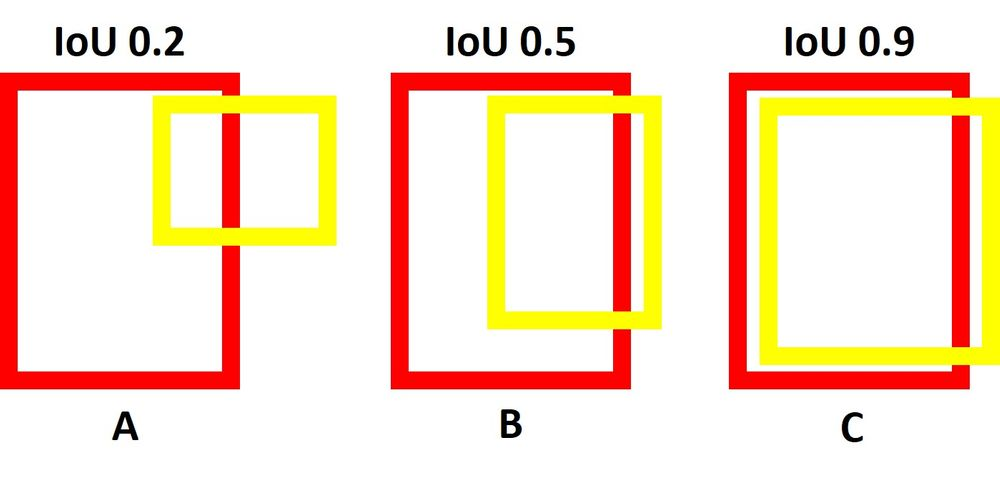
</div>


In [15]:
def compute_IoU(output, target):
    
    bboxes_output = from_grid_coordinate_to_bbox(output,iou_flag=True)
    bboxes_target = from_grid_coordinate_to_bbox(target,iou_flag=True)
    
    #print(f"bboxes_output = {bboxes_output}")
    
    ious = []
    for out_box in bboxes_output:
        for target_box in bboxes_target:
            
            row_out = out_box[1]
            row_target = target_box[1]
            col_out = out_box[2]
            col_target = target_box[2]
            
            # it means that is the same bounding box, predicted vs ground truth
            if row_out == row_target and col_out == col_target:
                
                x_center_output = out_box[0][0]
                y_center_output = out_box[0][1]
                width_output = out_box[0][2]
                heigth_output = out_box[0][3]

                x_center_target = target_box[0][0]
                y_center_target = target_box[0][1]
                width_target = target_box[0][2]
                heigth_target = target_box[0][3]


                # first convert from the YOLO format to (x_min, y_min, x_max, y_max)
                xmin_output = (2*x_center_output - width_output) / 2
                ymin_output = (2*y_center_output - heigth_output) / 2
                xmax_output = (2*x_center_output + width_output) / 2 
                ymax_output = (2*y_center_output + heigth_output) / 2

                boxA = [xmin_output, ymin_output, xmax_output, ymax_output]

                xmin_target = (2*x_center_target - width_target) / 2
                ymin_target = (2*y_center_target - heigth_target) / 2
                xmax_target = (2*x_center_target + width_target) / 2 
                ymax_target = (2*y_center_target + heigth_target) / 2

                boxB = [xmin_target, ymin_target, xmax_target, ymax_target]

                # determine the (x, y)-coordinates of the intersection rectangle
                xA = max(boxA[0], boxB[0])
                yA = max(boxA[1], boxB[1])
                xB = min(boxA[2], boxB[2])
                yB = min(boxA[3], boxB[3])
                # compute the area of intersection rectangle
                interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
                # compute the area of both the prediction and ground-truth
                # rectangles
                boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
                boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
                # compute the intersection over union by taking the intersection
                # area and dividing it by the sum of prediction + ground-truth
                # areas - the interesection area
                iou = interArea / float(boxAArea + boxBArea - interArea)
                
                ious.append((iou, row_out, col_out))
    
    return ious

In [16]:
def show_image_and_bbox_target_and_output(image, out, target, filename, training=False):
    
    image_np = None

    # if a filename is not provided, a 128 x 128 image is displayed
    if filename == None:
        image = image[0]

        if image.shape == torch.Size([3, 128, 128]):
            image_np = image.permute(1, 2, 0).numpy()

    # if a filename is provided, the 676 x 380 image is displayed
    else:
        img_path = os.path.join("/kaggle/input/car-object-detection/data/testing_images", filename)
    
        if training == True:
            img_path = os.path.join("/kaggle/input/car-object-detection/data/training_images", filename)
    
        image = Image.open(img_path).convert("RGB")
        image_np = np.array(image)
            
    # Plot the image with bounding boxes
    fig, ax = plt.subplots(1)
    ax.imshow(image_np)
    
    bboxes_out = from_grid_coordinate_to_bbox(out)
    bboxes_target = from_grid_coordinate_to_bbox(target)
    
    # Create patches for the legend
    pred_patch = patches.Patch(color='red', label='Predicted')
    gt_patch = patches.Patch(color='green', label='Ground Truth')

    for box in bboxes_out:
        
        #print(f"box = {box}")

        x_center = box[0]
        y_center = box[1]
        width = box[2]
        height = box[3]
        
        xmin = (2*x_center - width) / 2
        ymin = (2*y_center - height) / 2
        xmax = (2*x_center + width) / 2
        ymax = (2*y_center + height) / 2
        
        rect = None
        # if a filename is not provided, the image is 128 x 128 and so the box should be
        if filename == None:
            rect = patches.Rectangle((xmin, ymin), width, height, linewidth=2, edgecolor='r', facecolor='none')
        
        # if the image is 676 x 380, the rectangle must be scaled
        else:
            bbox = scale_to_range(bboxes=[[xmin, ymin, xmax, ymax]], old_x=128, old_y=128, new_x=676, new_y=380)
            bbox = bbox[0]
            xmin = bbox[0]
            ymin = bbox[1]
            xmax = bbox[2]
            ymax = bbox[3]
            width = xmax - xmin
            height = ymax - ymin
            rect = patches.Rectangle((xmin, ymin), width, height, linewidth=2, edgecolor='r', facecolor='none')
        
        
        # Add the patch to the Axes
        ax.add_patch(rect)
        
        
        confidence_score = box[4]
        ax.text(xmin, ymin - 5, f'{confidence_score:.4f}', color='white', fontsize=12, bbox=dict(facecolor='red', alpha=0.5))

        
    for box in bboxes_target:
        
        x_center = box[0]
        y_center = box[1]
        width = box[2]
        height = box[3]
        
        xmin = (2*x_center - width) / 2
        ymin = (2*y_center - height) / 2
        xmax = (2*x_center + width) / 2
        ymax = (2*y_center + height) / 2
        
        rect = None
        # if a filename is not provided, the image is 128 x 128 and so the box should be
        if filename == None:
            rect = patches.Rectangle((xmin, ymin), width, height, linewidth=2, edgecolor='g', facecolor='none')
        
        # if the image is 676 x 380, the rectangle must be scaled
        else:
            bbox = scale_to_range(bboxes=[[xmin, ymin, xmax, ymax]], old_x=128, old_y=128, new_x=676, new_y=380)
            bbox = bbox[0]
            xmin = bbox[0]
            ymin = bbox[1]
            xmax = bbox[2]
            ymax = bbox[3]
            width = xmax - xmin
            height = ymax - ymin
            rect = patches.Rectangle((xmin, ymin), width, height, linewidth=2, edgecolor='g', facecolor='none')
        
        
        # Add the patch to the Axes
        ax.add_patch(rect)
    
    # Add the legend to the plot
    ax.legend(handles=[pred_patch, gt_patch], loc='upper right')
    
    plt.axis('off')  # Turn off axis
    plt.show()
    
    return 

filename = vid_5_31140.jpg randomly chosen


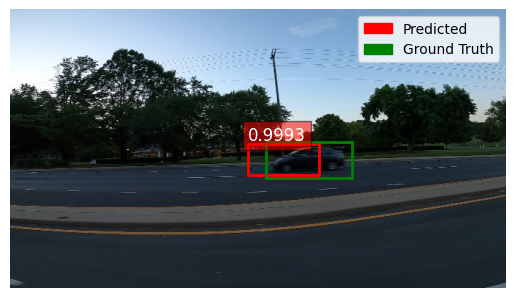

---------- RESULTS ----------
IoU for bbox (grid row, grid column) = (2, 2): 0.4684564565548202 

Average Precision: 1.0


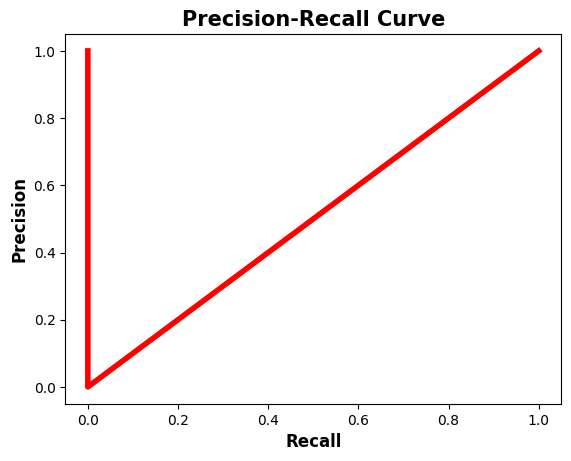

In [23]:
test_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

test_img_dir = '/kaggle/input/car-object-detection/data/testing_images'
file_list = os.listdir(test_img_dir)
TEST_SET_SIZE = len(file_list)

random_number = random.randint(0, TEST_SET_SIZE)

filename = None

image = None
target = None
for i in range(TEST_SET_SIZE):
    if i == random_number:
        filename = file_list[i]
        print(f"filename = {filename} randomly chosen")

        target = test_image_boxes[filename]

        img_path = os.path.join(test_img_dir, filename)

        image = Image.open(img_path).convert("RGB")

        break 


image = test_transform(image)
image = image.unsqueeze(0)
image = image.to(device)

model.eval()

with torch.no_grad():

    out = model(image)
    
    # giving filename to the function, it displays the result in 676 x 380
    # without it, it displays it in 128 x 128

    # if training = true you want to use images from the training set
    # this function is used to show in the same image both the ground truth and the predicted boxes
    show_image_and_bbox_target_and_output(image.cpu, out, target, filename, training=False)
    
    print("---------- RESULTS ----------")
    
    AP, precisions, recalls = compute_mAP(out=out, target=target, thresholds=thresholds)
    IoUs = compute_IoU(output=out, target=target)
    
    if IoUs != []:
        for IoU in IoUs:
            print(f"IoU for bbox (grid row, grid column) = ({IoU[1]}, {IoU[2]}): {IoU[0]} \n")

    
    print(f"Average Precision: {AP}")
    
    
    # Add a small epsilon to avoid division by zero, but handle the cases where both are zero
    epsilon = 1e-10
    f1_scores = 2 * ((precisions * recalls) / (precisions + recalls + epsilon))

    # Set F1 score to 0 where both precision and recall are 0 (instead of NaN)
    f1_scores[(precisions == 0) & (recalls == 0)] = 0
    

    
    plt.plot(recalls, precisions, linewidth=4, color="red")
    plt.xlabel("Recall", fontsize=12, fontweight='bold')
    plt.ylabel("Precision", fontsize=12, fontweight='bold')
    plt.title("Precision-Recall Curve", fontsize=15, fontweight="bold")
    plt.show()